#### Create environment with PaCMAP 0.7.2
```
conda create -n pacmap python=3.12 ipykernel pandas fastparquet matplotlib
conda activate pacmap
conda install -c conda-forge libstdcxx-ng   
pip install pacmap==0.7.2
```

In [4]:
import pacmap
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from pathlib import Path

In [5]:
assert pacmap.__version__ == '0.7.2'

In [6]:
DATA_PATH = Path("../data")  # specify data directory

# Load data

#### Note: Download the `embeddings.zip` file as instructed in the README. After downloading, unzip it and move the extracted contents into the `data` folder.

In [7]:
coordinates = pd.read_parquet(DATA_PATH / 'coordinates.parquet')

In [8]:
basis = np.load(DATA_PATH / 'embeddings' / 'basis.npz')['matrix']
keys = np.load(DATA_PATH / 'embeddings' / 'keys.npz')['matrix']
indices = np.loadtxt(DATA_PATH / 'embeddings' / 'indices.txt', dtype=str)

###  PacMAP model used in the paper

In [9]:
with open(DATA_PATH / 'embeddings' / 'pacmap_unnormed.pkl', 'rb') as handle:
    pacmap_unnormed = pickle.load(handle)
with open(DATA_PATH/ 'embeddings' /'pacmap_normed.pkl', 'rb') as handle:
    pacmap_normed = pickle.load(handle)

/tmp/ipykernel_4120240/3915022605.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  pacmap_unnormed = pickle.load(handle)
/home/PawelSz/miniconda3/envs/pacmap/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainabilit

### CATH

In [10]:
X_cath = np.load(DATA_PATH / 'embeddings' / 'cath_shapemers.npz')['matrix']
with open(DATA_PATH / 'embeddings' / 'cath_keys.txt', 'r') as f:
    keys_cath = f.readlines()
keys_cath = list(map(lambda x: x.strip(), keys_cath))
indices_cath = pd.read_csv(DATA_PATH / 'embeddings' / 'cath_indices.txt', header=None)
indices_cath = list(indices_cath[0].str.replace('.pdb', ''))

### ProtGPT2

In [11]:
X_protgpt2 = np.load(DATA_PATH / 'embeddings' / 'protgpt2_shapemers.npz')['matrix']
with open(DATA_PATH / 'embeddings' / 'protgpt2_keys.txt', 'r') as f:
    keys_protgpt2 = f.readlines()
keys_protgpt2 = list(map(lambda x: x.strip(), keys_protgpt2))
indices_protgpt2 = pd.read_csv(DATA_PATH / 'embeddings' / 'protgpt2_indices.txt', header=None)
indices_protgpt2 = list(indices_protgpt2[0].str.replace('.pdb', ''))

### BFVD

In [12]:
X_bfvd, indices_bfvd, keys_bfvd = {}, {}, {}
# keys
for subpath in (DATA_PATH / 'embeddings' / 'bfvd').glob('*keys.txt'):
    batch = int(subpath.stem.split('_')[0])
    with open(subpath, 'r') as f:
        keys_bfvd[batch] = f.readlines()
    keys_bfvd[batch] = list(map(lambda x: x.strip(), keys_bfvd[batch]))
# indices
for subpath in (DATA_PATH / 'embeddings' / 'bfvd').glob('*indices.txt'):
    batch = int(subpath.stem.split('_')[0])
    indices_bfvd[batch] = pd.read_csv(subpath, header=None)
    indices_bfvd[batch] = list(indices_bfvd[batch][0].\
                                        str.replace('.pdb', '').str.replace('.cif', ''))
# shapemers
for subpath in (DATA_PATH / 'embeddings' / 'bfvd').glob('*shapemers.npz'):
    batch = int(subpath.stem.split('_')[0])
    X_bfvd[batch] = np.load(subpath)['matrix']

In [13]:
indices_bfvd = np.concatenate([indices_bfvd[k] for k in X_bfvd.keys()], axis=0)

# Inference (`transform`)

Below, we transform CATH, ProGPT2 and BFVD datasets using pre-trained PacMAP model.

## CATH

In [11]:
X_cath.shape

(6631, 726)

In [12]:
assert len(set(keys_cath)) == len(keys_cath)
# which columns are missing?
adds = list(set(keys) - set(keys_cath))
# find order wrt all columns
sorter_1 = pd.concat([
    pd.DataFrame(index=keys_cath, data={'idx_1': range(len(keys_cath))}),
    pd.DataFrame(index=adds, data={'idx_1': range(len(keys_cath), len(keys_cath) + len(adds))})
])
sorter_2 = pd.DataFrame(index=keys, data={'idx_2': range(len(keys))})
# add zero columns
X_cath_new = np.concatenate([X_cath, np.zeros([X_cath.shape[0], len(adds)])], axis=1)
# change column order
X_cath_new = X_cath_new[:, sorter_2.join(sorter_1).idx_1.values]

In [13]:
X_cath_pacmap_trans_normed = pacmap_normed.transform(X_cath_new, basis=basis)

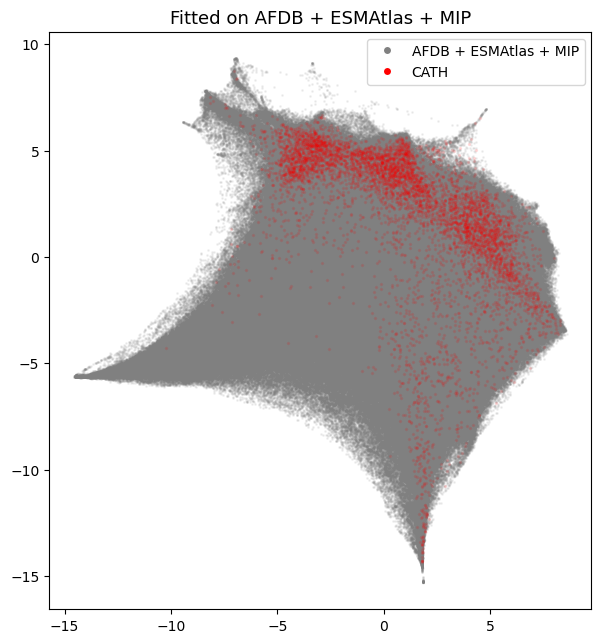

In [14]:
plt.figure(figsize=(7, 7.5))
plt.scatter(coordinates['x'], coordinates['y'], alpha=0.1, c='gray', s=1)
plt.scatter(X_cath_pacmap_trans_normed[:, 0], X_cath_pacmap_trans_normed[:, 1], alpha=0.1, c='r', s=2)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AFDB + ESMAtlas + MIP',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='CATH',
           markerfacecolor='r', markersize=6)
]
plt.title('Fitted on AFDB + ESMAtlas + MIP', size=13)
plt.gca().set_aspect('equal')
plt.legend(handles=legend_elements)
plt.show()

## ProtGPT2

In [15]:
X_protgpt2.shape

(10000, 687)

In [16]:
assert len(set(keys_protgpt2)) == len(keys_protgpt2)
# which columns are missing?
adds = list(set(keys) - set(keys_protgpt2))
# find order wrt all columns
sorter_1 = pd.concat([
    pd.DataFrame(index=keys_protgpt2, data={'idx_1': range(len(keys_protgpt2))}),
    pd.DataFrame(index=adds, data={'idx_1': range(len(keys_protgpt2), len(keys_protgpt2) + len(adds))})
])
sorter_2 = pd.DataFrame(index=keys, data={'idx_2': range(len(keys))})
# add zero columns
X_protgpt2_new = np.concatenate([X_protgpt2, np.zeros([X_protgpt2.shape[0], len(adds)])], axis=1)
# change column order
X_protgpt2_new = X_protgpt2_new[:, sorter_2.join(sorter_1).idx_1.values]

In [17]:
X_protgpt2_pacmap_trans_normed = pacmap_normed.transform(X_protgpt2_new, basis=basis)

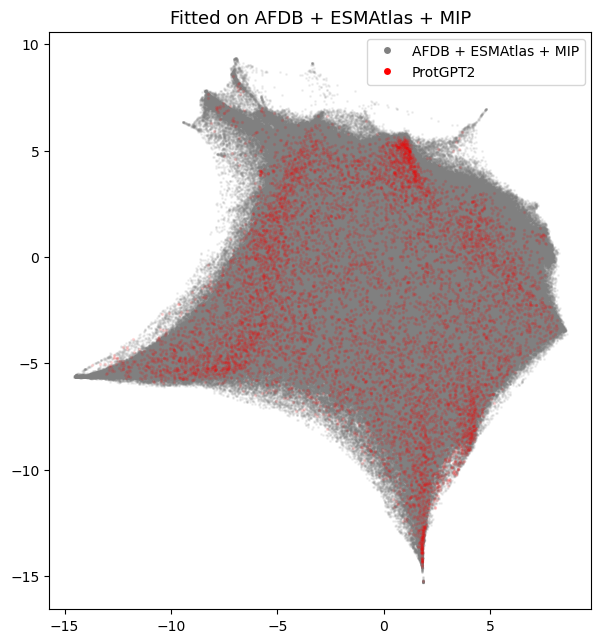

In [18]:
plt.figure(figsize=(7, 7.5))
plt.scatter(coordinates['x'], coordinates['y'], alpha=0.1, c='gray', s=1)
plt.scatter(X_protgpt2_pacmap_trans_normed[:, 0], 
            X_protgpt2_pacmap_trans_normed[:, 1], alpha=0.1, c='r', s=2)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AFDB + ESMAtlas + MIP',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='ProtGPT2',
           markerfacecolor='r', markersize=6)
]
plt.title('Fitted on AFDB + ESMAtlas + MIP', size=13)
plt.gca().set_aspect('equal')
plt.legend(handles=legend_elements)
plt.show()

## BFVD

### Merge batches

In [30]:
all_keys_bfvd = list(set().union(*[set(el) for el in keys_bfvd.values()]))
assert len(set(all_keys_bfvd)) == len(all_keys_bfvd)

In [31]:
X_bfvd_new = {}
for k, v in X_bfvd.items():
    assert len(set(keys_bfvd[k])) == len(keys_bfvd[k])
    # which columns are missing?
    adds = list(set(all_keys_bfvd) - set(keys_bfvd[k]))
    # find order wrt all columns
    sorter_1 = pd.concat([
        pd.DataFrame(index=keys_bfvd[k], data={'idx_1': range(len(keys_bfvd[k]))}),
        pd.DataFrame(index=adds, data={'idx_1': range(len(keys_bfvd[k]), len(keys_bfvd[k]) + len(adds))})
    ])
    sorter_2 = pd.DataFrame(index=all_keys_bfvd, data={'idx_2': range(len(all_keys_bfvd))})
    # add zero columns
    X_bfvd_new[k] = np.concatenate([v, np.zeros([v.shape[0], len(adds)])], axis=1)
    # change column order
    X_bfvd_new[k] = X_bfvd_new[k][:, sorter_2.join(sorter_1).idx_1.values]

In [32]:
X_bfvd_merged = np.concatenate([v for v in X_bfvd_new.values()], axis=0)
X_bfvd_merged.shape

(351242, 806)

In [33]:
# which columns are missing?
adds = list(set(keys) - set(all_keys_bfvd))
# find order wrt all columns
sorter_1 = pd.concat([
    pd.DataFrame(index=all_keys_bfvd, data={'idx_1': range(len(all_keys_bfvd))}),
    pd.DataFrame(index=adds, data={'idx_1': range(len(all_keys_bfvd), len(all_keys_bfvd) + len(adds))})
])
sorter_2 = pd.DataFrame(index=keys, data={'idx_2': range(len(keys))})
# add zero columns
X_bfvd_merged_new = np.concatenate([X_bfvd_merged, np.zeros([X_bfvd_merged.shape[0], len(adds)])], axis=1)
# change column order
X_bfvd_merged_new = X_bfvd_merged_new[:, sorter_2.join(sorter_1).idx_1.values]

In [23]:
X_bfvd_pacmap_trans_normed = pacmap_normed.transform(X_bfvd_merged_new, basis=basis)

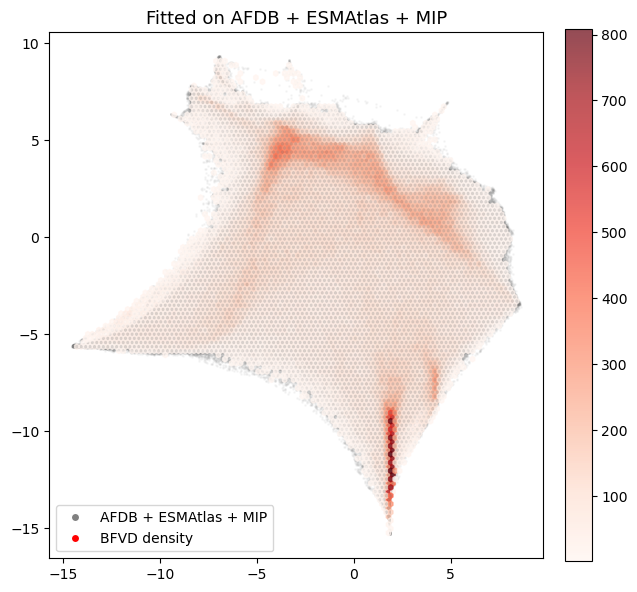

In [24]:
fig = plt.figure(figsize=(7, 7.5))
ax = plt.axes()
plt.scatter(coordinates['x'], coordinates['y'], alpha=0.05, c='gray', s=1)
hb = plt.hexbin(X_bfvd_pacmap_trans_normed[:, 0], 
                X_bfvd_pacmap_trans_normed[:, 1], 
                gridsize=100, cmap='Reds', mincnt=1, alpha=0.7)
cb = plt.colorbar(hb, fraction=0.049, pad=0.04)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AFDB + ESMAtlas + MIP',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='BFVD density',
           markerfacecolor='r', markersize=6)
]
plt.title('Fitted on AFDB + ESMAtlas + MIP', size=13)
ax.set_aspect('equal')
plt.legend(handles=legend_elements, loc=3)
plt.show()

# Training (`fit_transform`)

Below, we fit and transform PacMAP model on our initial database (AFDB+ESMAtlas+MIP) combined with ProGPT2 or BFVD.

**Note:** Running PaCMAP — even with the same version — may yield slightly different coordinates (mostly in the middle of the graph i.e. near (0,0)) due to variations in library or dependency versions, meaning full portability is not guaranteed. However, this does not affect the qualitative or quantitative conclusions.

#### Optimal parameters taken from grid search

In [14]:
 # unnormalized input
n_neighbors_unn = 13
MN_ratio_unn = 1.9
FP_ratio_unn = 1.5
# normalized input
n_neighbors_norm = 10
MN_ratio_norm = 1.3
FP_ratio_norm = 0.9

## Unnormalized

In [26]:
%%time
embedding_unnormed = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors_unn, 
                          MN_ratio=MN_ratio_unn, FP_ratio=FP_ratio_unn, random_state=1) 
X_pacmap_unnormed = embedding_unnormed.fit_transform(basis, init="pca")

/home/PawelSz/miniconda3/envs/pacmap/lib/python3.12/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


CPU times: user 45min 10s, sys: 18.1 s, total: 45min 28s
Wall time: 35min


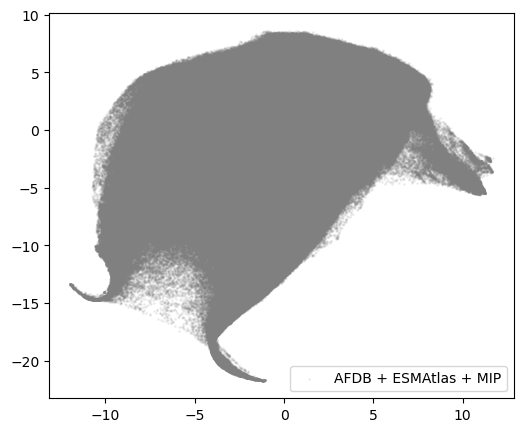

In [40]:
plt.figure(figsize=(6, 5))
plt.scatter(X_pacmap_unnormed[:, 0], X_pacmap_unnormed[:, 1], 
            alpha=0.1, c='gray', s=1, label='AFDB + ESMAtlas + MIP')
plt.legend();

## Normalized

In [15]:
X_norm = (basis.T / basis.sum(axis=1)).T

In [42]:
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors_norm, 
                          MN_ratio=MN_ratio_norm, FP_ratio=FP_ratio_norm, random_state=1) 
X_pacmap = embedding.fit_transform(X_norm, init="pca")

/home/PawelSz/miniconda3/envs/pacmap/lib/python3.12/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


/home/PawelSz/miniconda3/envs/pacmap/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/PawelSz/miniconda3/envs/pacmap/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


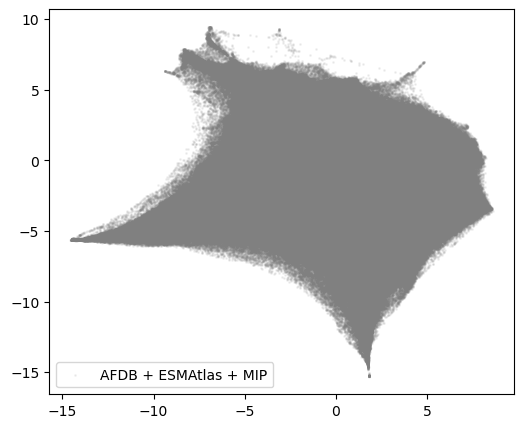

In [47]:
plt.figure(figsize=(6, 5))
plt.scatter(X_pacmap[:, 0], X_pacmap[:, 1], alpha=0.1, c='gray', s=1, label='AFDB + ESMAtlas + MIP')
plt.legend();

## With ProtGPT2 (normalized)

### Concatenate indices

In [16]:
indices_concat = np.concatenate([indices, indices_protgpt2], axis=0)

### Merge keys

In [17]:
all_keys = list(set().union(*[set(el) for el in [keys, keys_protgpt2]]))
assert len(set(all_keys)) == len(all_keys)
len(all_keys)

844

### Sort embeddings

In [25]:
X_dict = {'basis': basis, 'protgpt2': X_protgpt2}
keys_dict = {'basis': keys, 'protgpt2': keys_protgpt2}

In [19]:
X_dict_new = {}
for key in X_dict.keys():
    print(key)
    X_dict_new[key] = {}
    assert len(set(keys_dict[key])) == len(keys_dict[key])
    # which columns are missing?
    adds = list(set(all_keys) - set(keys_dict[key]))
    # find order wrt all columns
    sorter_1 = pd.concat([
        pd.DataFrame(index=keys_dict[key], data={'idx_1': range(len(keys_dict[key]))}),
        pd.DataFrame(index=adds, data={'idx_1': range(len(keys_dict[key]), len(keys_dict[key]) + len(adds))})
    ])
    sorter_2 = pd.DataFrame(index=all_keys, data={'idx_2': range(len(all_keys))})
    # add zero columns
    X_dict_new[key] = np.concatenate([X_dict[key], np.zeros([X_dict[key].shape[0], len(adds)])], axis=1)
    # change column order
    X_dict_new[key] = X_dict_new[key][:, sorter_2.join(sorter_1).idx_1.values]

basis
protgpt2


In [20]:
X_with_protgpt2 = np.concatenate([v for v in X_dict_new.values()], axis=0)
X_with_protgpt2_norm = (X_with_protgpt2.T / X_with_protgpt2.sum(axis=1)).T
print(X_with_protgpt2.shape)

(1515141, 844)


### Fit PaCMAP

In [ ]:
embedding_with_protgpt2 = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors_norm, 
                          MN_ratio=MN_ratio_norm, FP_ratio=FP_ratio_norm, random_state=1) 
X_pacmap_with_protgpt2 = embedding_with_protgpt2.fit_transform(X_with_protgpt2_norm, init="pca")

/home/PawelSz/miniconda3/envs/pacmap/lib/python3.12/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


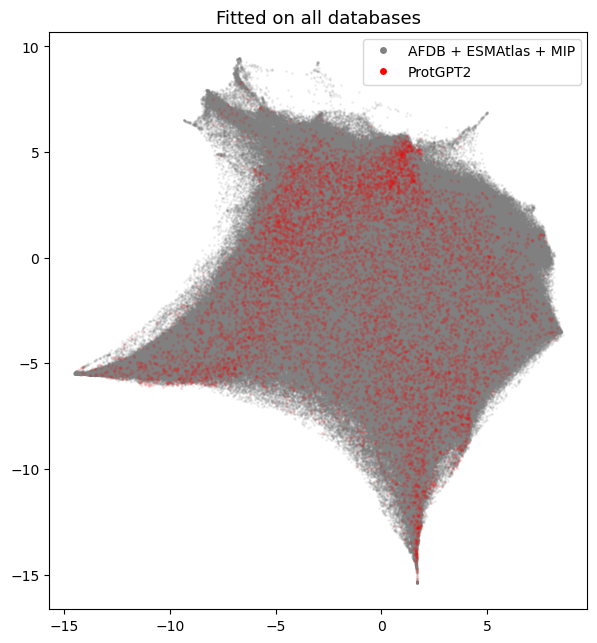

In [26]:
plt.figure(figsize=(7, 7.5))
plt.scatter(X_pacmap_with_protgpt2[:-len(indices_protgpt2), 0], 
            X_pacmap_with_protgpt2[:-len(indices_protgpt2), 1], 
            alpha=0.1, c='gray', s=1)
plt.scatter(X_pacmap_with_protgpt2[-len(indices_protgpt2):, 0], 
            X_pacmap_with_protgpt2[-len(indices_protgpt2):, 1], 
            alpha=0.1, c='r', s=2)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AFDB + ESMAtlas + MIP',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='ProtGPT2',
           markerfacecolor='r', markersize=6)
]
plt.title('Fitted on all databases', size=13)
plt.gca().set_aspect('equal')
plt.legend(handles=legend_elements)
plt.show()

## With BFVD (normalized)

### Concatenate indices

In [28]:
indices_concat = np.concatenate([indices, indices_bfvd], axis=0)

### Merge keys

In [34]:
all_keys = list(set().union(*[set(el) for el in [keys, all_keys_bfvd]]))
assert len(set(all_keys)) == len(all_keys)
len(all_keys)

851

### Sort embeddings

In [35]:
X_dict = {'basis': basis, 'bfvd': X_bfvd_merged}
keys_dict = {'basis': keys, 'bfvd': all_keys_bfvd}

In [36]:
X_dict_new = {}
for key in X_dict.keys():
    print(key)
    X_dict_new[key] = {}
    assert len(set(keys_dict[key])) == len(keys_dict[key])
    # which columns are missing?
    adds = list(set(all_keys) - set(keys_dict[key]))
    # find order wrt all columns
    sorter_1 = pd.concat([
        pd.DataFrame(index=keys_dict[key], data={'idx_1': range(len(keys_dict[key]))}),
        pd.DataFrame(index=adds, data={'idx_1': range(len(keys_dict[key]), len(keys_dict[key]) + len(adds))})
    ])
    sorter_2 = pd.DataFrame(index=all_keys, data={'idx_2': range(len(all_keys))})
    # add zero columns
    X_dict_new[key] = np.concatenate([X_dict[key], np.zeros([X_dict[key].shape[0], len(adds)])], axis=1)
    # change column order
    X_dict_new[key] = X_dict_new[key][:, sorter_2.join(sorter_1).idx_1.values]

basis
bfvd


In [37]:
X_with_bfvd = np.concatenate([v for v in X_dict_new.values()], axis=0)
X_with_bfvd_norm = (X_with_bfvd.T / X_with_bfvd.sum(axis=1)).T
print(X_with_bfvd.shape)

(1856383, 851)


### Fit PaCMAP

In [ ]:
embedding_with_bfvd = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors_norm, 
                          MN_ratio=MN_ratio_norm, FP_ratio=FP_ratio_norm, random_state=1) 
X_pacmap_with_bfvd = embedding_with_bfvd.fit_transform(X_with_bfvd_norm, init="pca")

/home/PawelSz/miniconda3/envs/pacmap/lib/python3.12/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


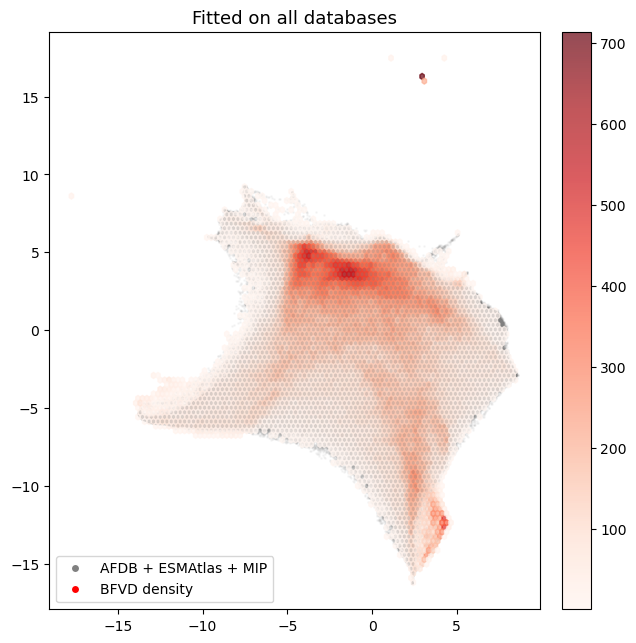

In [42]:
fig = plt.figure(figsize=(7, 7.5))
ax = plt.axes()
plt.scatter(X_pacmap_with_bfvd[:-len(indices_bfvd), 0], 
            X_pacmap_with_bfvd[:-len(indices_bfvd), 1], alpha=0.05, c='gray', s=1)
hb = plt.hexbin(X_pacmap_with_bfvd[-len(indices_bfvd):, 0], 
                X_pacmap_with_bfvd[-len(indices_bfvd):, 1], 
                gridsize=100, cmap='Reds', mincnt=1, alpha=0.7)
cb = plt.colorbar(hb, fraction=0.055, pad=0.04)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AFDB + ESMAtlas + MIP',
           markerfacecolor='gray', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='BFVD density',
           markerfacecolor='r', markersize=6)
]
plt.title('Fitted on all databases', size=13)
plt.legend(handles=legend_elements, loc=3)
plt.show()

### Outliers

In [41]:
left = np.argwhere((X_pacmap_with_bfvd[:,0]<-10) &\
                           (X_pacmap_with_bfvd[:,1]>15))
middle = np.argwhere((X_pacmap_with_bfvd[:,0]<3) &\
                           (X_pacmap_with_bfvd[:,1]>16))
right = np.argwhere((X_pacmap_with_bfvd[:,0]>3) &\
                           (X_pacmap_with_bfvd[:,1]>16))
big =  np.argwhere((X_pacmap_with_bfvd[:,0]>4.1) &\
                           (X_pacmap_with_bfvd[:,1]>15))
len(left), len(middle), len(right), len(big)

(0, 935, 16, 16)